In [26]:
import sys
import torch  
import numpy as np  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from torch.distributions.categorical import Categorical
import math
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from preprocess import mean, std, preprocess_input_function
from settings import train_dir, test_dir, train_push_dir, train_batch_size, test_batch_size, train_push_batch_size
from settings import base_architecture, img_size, prototype_shape, num_classes, prototype_activation_function, add_on_layers_type
from receptive_field import compute_rf_prototype
import cv2
from reward_model import construct_PrefNet, paired_cross_entropy_loss, PrefNet
from tqdm import tqdm
from settings import joint_optimizer_lrs, joint_lr_step_size
import skimage as sk
import skimage.io as skio
import train_and_test as tnt
from torch.utils.data import Subset
import time
import heapq

In [56]:
'''
Use PPnet's forward pass as the policy network (actor network); what about the network for value function (critic network)?
Since there are only determinant actions, this is essentially A2C...
'''
class A3C_PPnet(nn.Module):
    def __init__(self, PPnet, preference_model, k=1, p=5, learning_rate=1e-7, dummy_reward=False, train_batch_size=80):
        super(A3C_PPnet, self).__init__()
        
        
        self.PPnet = PPnet.cuda()
        self.k = k
        self.pf_model = preference_model.cuda()
        
        self.PPnet_multi = self.PPnet
        for p in self.PPnet_multi.module.features.parameters():
            p.requires_grad = False
        for p in self.PPnet_multi.module.add_on_layers.parameters():
            p.requires_grad = True
        self.PPnet_multi.module.prototype_vectors.requires_grad = True
        for p in self.PPnet_multi.module.last_layer.parameters():
            p.requires_grad = False
        
        #self.critic_model = self.construct_critic().cuda()
        self.p = p
        self.critic_model = Critic().cuda()
        for p in self.critic_model.parameters():
            p.requires_grad = True
        self.train_batch_size = train_batch_size
        self.num_epoch = 0
        policy_optimizer_specs = [#{'params': self.PPnet.features.parameters(), 'lr': joint_optimizer_lrs['features'], 'weight_decay': 1e-3}, 
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': joint_optimizer_lrs['add_on_layers'], 'weight_decay': 1e-3},
                                  #{'params': self.PPnet.prototype_vectors, 'lr': joint_optimizer_lrs['prototype_vectors']},
                                  #{'params': self.PPnet.add_on_layers.parameters(), 'lr': 1e-6, 'weight_decay': 0},
                                  {'params': self.PPnet.module.prototype_vectors, 'lr': 1e-5, 'weight_decay': 1e-3}
            
                                  ]
        self.policy_optimizer = torch.optim.Adam(policy_optimizer_specs)
        #self.policy_optimizer = torch.optim.Adam(self.PPnet.features.parameters())
        self.critic_optimizer = torch.optim.Adam(self.critic_model.parameters(), lr=1e-4)
        self.num_iteration = 0
        self.p_avg = torch.zeros(1000)
        self.p_count = torch.zeros(1000)
        
    def get_heatmaps(self, batch_x, labels, dummy=False, track=False, save_prototypes=[], save_epochs=[]):
        self.PPnet_multi.eval()
        n_prototypes = self.PPnet_multi.module.num_prototypes
        prototype_shape = self.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = self.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        protoL_input_torch, proto_dist_torch = self.PPnet_multi.module.push_forward(batch_x)
        
        proto_dist_ = proto_dist_torch.view(proto_dist_torch.shape[0], proto_dist_torch.shape[1], -1)
        distances = torch.amin(proto_dist_, axis=-1)
       
        actions, p_idx = self.sample_from_distances(distances, labels, track=track)
        #print("p_idx: ", p_idx)
        proto_dist = torch.clone(proto_dist_torch)
       
        proto_dist = torch.transpose(proto_dist, 0, 1)
        proto_dist = proto_dist.detach().cpu().numpy()
        
        joint_log_probs = []
        original_imgs = []
        rescaled_patterns = []
        
        for action in actions:
            img_idx, probs, j, class_identity = action[0], action[1], action[2], action[3]
            
            original_imgs_j = []
            rescaled_patterns_j = []
           
            for i in img_idx:
                
                closest_patch_indices_in_distance_map_j = list(np.unravel_index(np.argmin(proto_dist[j][i],axis=None), proto_dist[j][i].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                
                closest_patch_indices_in_img = compute_rf_prototype(batch_x.size(2), closest_patch_indices_in_distance_map_j, protoL_rf_info)
                closest_patch = \
                    batch_x[i, :, closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2], closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.cpu().numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = batch_x[i].cpu().numpy()
                original_img = np.transpose(original_img, (1, 2, 0))
                
                
                if self.PPnet_multi.module.prototype_activation_function == 'log':
                    act_pattern = np.log((proto_dist[j][i] + 1)/(proto_dist[j][i] + self.PPnet_multi.module.epsilon))
                elif self.PPnet_multi.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - proto_dist[j][i]
                else:
                    act_pattern = prototype_activation_function_in_numpy(proto_dist[j][i])

                patch_indices = closest_patch_indices_in_img[1:5]
                          
                upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                
                original_img = original_img - np.amin(original_img)
                original_img = original_img / np.amax(original_img)
                original_imgs_j.append(original_img)
                rescaled_patterns_j.append(rescaled_act_pattern)
                
                
            joint_log_prob = torch.prod(probs) * math.factorial(self.k)
            original_imgs.append(original_imgs_j)
            rescaled_patterns.append(rescaled_patterns_j)

            joint_log_probs.append(joint_log_prob)
    
        return original_imgs, rescaled_patterns, joint_log_probs, distances, p_idx
    
    def sample_from_distances(self, distances, labels, track_iters=[], track=False):
        '''
        Takes in distances of shape (80, 1000)
        returns actions of shape (1000, ), one for each prototype
        '''
        
        distances = torch.clip(distances, min=1e-7, max=None)
        similarities = 1 / distances
        #print(similarities)
        softmax_dist = F.log_softmax(similarities, dim=0)
        softmax_dist = torch.transpose(softmax_dist, 0, 1)
        # Maybe using combinatorics?
        actions = []
        p_idx = []
        # For each of the 1000 prototypes...
        for i in range(softmax_dist.shape[0]):
            class_identity = torch.argmax(self.PPnet_multi.module.prototype_class_identity[i])

            class_dist = softmax_dist[i][labels==class_identity]
            if len(class_dist) > self.k:
                dist = Categorical(class_dist)
                img_idx = dist.sample(sample_shape=torch.tensor([self.k]))
                probs = dist.log_prob(img_idx)
                probs = torch.exp(probs)
                actions.append([img_idx, probs, i, class_identity])
                p_idx.append(i)
        return actions, p_idx
    

    def get_critic_inputs(self, imgs, patterns, dummy=False):
        critic_inputs = []
        for i in range(len(imgs)):
            #x = np.concatenate(heatmaps[i], axis=1)
            #print(x.shape)
            x = imgs[i]
            
            x = np.transpose(x, (0, 3, 1, 2))
            x = torch.tensor(x).cuda()
            
            p = patterns[i][0]
            p = np.array([p, p, p])
            p = torch.from_numpy(np.array([p])).cuda()
            with torch.no_grad():
                x = self.pf_model.conv_features(x)
                p = self.pf_model.conv_features(p)
            
            critic_inputs.append((x, p))
       
        return critic_inputs
        
    def critic(self, critic_inputs):
        values = torch.zeros(len(critic_inputs))
        for i in range(len(critic_inputs)):
            value = self.critic_model(critic_inputs[i][0], critic_inputs[i][1])
            values[i] = value
        return values
    
    '''
    imgs: (1000, 1, 224, 224, 3), patterns: (1000, 1, 224, 224)
    '''
    def get_rewards(self, imgs, patterns, dummy=False):
        
        with torch.no_grad():
            rewards = torch.empty(len(imgs))
            for i in range(len(imgs)):
                
                img = np.array(imgs[i])
                img = np.transpose(img, (0, 3, 1, 2))
                img = torch.from_numpy(img).cuda()
                
                pattern = patterns[i][0]
                pattern = np.array([pattern, pattern, pattern])
                pattern = torch.from_numpy(np.array([pattern])).cuda()
                reward = self.pf_model(img, pattern) 
                rewards[i] = reward + 15
                
        return rewards
        
    def update_v1(self, rewards, values, probs, p_idx):
        assert len(p_idx) == len(rewards)
        self.policy_optimizer.zero_grad()
        policy_loss = 0
        '''
        Customized A2C
        '''
        for i in range(len(rewards)):
            policy_loss -= probs[i] * (rewards[i] - values[i])    
        policy_loss.backward(retain_graph=True)
        self.policy_optimizer.step()
        for i in range(len(rewards)):
            pid = p_idx[i]
            self.p_avg[pid] = (self.p_avg[pid] * self.p_count[pid] + rewards[i]) / (self.p_count[pid]+1)
            self.p_count[pid] += 1
        #print("avg: ", self.p_avg)
        #print("count: ", self.p_count)
        #self.critic_optimizer.zero_grad()
        #critic_loss = 0
        #for i in range(len(rewards)):
        #    critic_loss += (rewards[i] - values[i]) ** 2
        
        #critic_loss.backward()
        #self.critic_optimizer.step()
        
        return 
    
    
    def run(self, batch_x, labels, save_prototypes=[], save_epochs=[], track=False):

        # action is n_prototypes * k heatmaps
        original_imgs, rescaled_patterns, probs, img_distances, p_idx = self.get_heatmaps(batch_x, labels, track=track)
        
        #critic_inputs = self.get_critic_inputs(original_imgs, rescaled_patterns)
        #values = self.critic(critic_inputs)
        values = self.p_avg
        '''
        A simple running average as the critic outputs
        '''
        
        rewards = self.get_rewards(original_imgs, rescaled_patterns)
        
        self.update_v1(rewards, values, probs, p_idx)
        
        self.num_iteration += 1
        if self.num_iteration == 75:
            self.num_iteration = 0
            self.num_epoch += 1
        
        return rewards, values, probs
    '''
    
    def run_dummy(self, batch_x, labels, save_prototypes=[], save_epochs=[], track=False):
        heatmaps, probs, img_distances, rewards  = self.get_heatmaps(batch_x, labels, dummy=True, track=track, save_prototypes=save_prototypes, save_epochs=save_epochs)
        
        critic_inputs = self.get_critic_inputs(heatmaps)
        values = self.critic_model(critic_inputs)
        #values = []
        self.update_v1(rewards, values, probs)
        #if len(save_prototypes) > 0 and self.num_iteration in save_iters:
        #    for p in save_prototypes:
        #        
        #        for k in range(len(heatmaps[p])):
        #            plt.imsave(r'./A3C_results/epoch_'+str(self.num_epoch)+'_prototype_'+str(p)+'_best_'+str(k+1)+'_dummy.jpg', heatmaps[p][k])
            
        self.num_iteration += 1
        if self.num_iteration == 75:
            self.num_iteration = 0
            self.num_epoch += 1
        
        return rewards, values, probs, heatmaps
    '''
    
    

In [57]:
class Critic(nn.Module):
    def __init__(self, k=3, learning_rate=3e-4):
        super(Critic, self).__init__()
        
        '''
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
        '''
        
        self.img_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.pattern_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.Sigmoid()
            )
        
        self.fc1 = nn.Linear(6400, 512)
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x ,p):

        x = self.img_conv(x)
        p = self.pattern_conv(p)
    
        out = torch.cat((x, p), dim=1)
        out = torch.flatten(out, 1) # flatten all dimensions except batch

        out = torch.sigmoid(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        out = self.fc3(out)

        return out

In [58]:
def reselect_prototypes(a3c, reward_threshold, data_loader, original_imgs, patterns):
    # get the heatmaps by searching for the closest images in the entire dataset
    # can use different k values
    # heatmaps: (1000, 1, 224, 224, 3)
    # rewards: (1000,)
    prototype_shape = a3c.PPnet_multi.module.prototype_shape
    bad_prototype_idx = []
    rewards = a3c.get_rewards(original_imgs, patterns)
    for i in range(len(rewards)):
        if rewards[i] < reward_threshold:
            bad_prototype_idx.append(i)
    print("bad prototype number: ", len(bad_prototype_idx))
    global_max_rewards = np.zeros((200, 5))
    global_best_patches = torch.zeros((200, 5, 128, 1, 1)).cuda()
    
    class_comps = np.zeros((200, 5))
    
    for idx, (batch_x, labels) in tqdm(enumerate(data_loader)):
        a3c.PPnet_multi.eval()
        n_prototypes = a3c.PPnet_multi.module.num_prototypes
        prototype_shape = a3c.PPnet_multi.module.prototype_shape
        max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]
        protoL_rf_info = a3c.PPnet_multi.module.proto_layer_rf_info
        
        batch_x = batch_x.cuda()
        # conv_outs: (80, 128, 7, 7)
        conv_outs = a3c.PPnet_multi.module.conv_features(batch_x)

        # loop over each prototype
        for j in bad_prototype_idx:
            class_identity = torch.argmax(a3c.PPnet_multi.module.prototype_class_identity[j])
            batch_idx = np.arange(batch_x.shape[0])
            class_idx_batch = batch_idx[labels == class_identity]
            #print(class_idx_batch)
            class_outs = conv_outs[labels == class_identity]
            if class_outs.shape[0] == 0:
                continue
            height = class_outs.shape[2]
            width = class_outs.shape[3]
            
            for img_idx in range(class_outs.shape[0]):
                img_max_reward = 0
                img_best_patch = a3c.PPnet_multi.module.prototype_vectors.data[j]
                for h in range(height):
                    for w in range(width):
                        # actually old_vec might not be necessary
                        # old_vec = np.copy(a3c.PPnet_multi.module.prototype_vectors.data[j])
                        patch_candidate = class_outs[img_idx, :, h:h+1, w:w+1]
                        a3c.PPnet_multi.module.prototype_vectors.data[j] = patch_candidate
                        #a3c.PPnet_multi.module.prototype_vectors.data.copy_(vec)
                        # distances: (7, 7)
                        distances = a3c.PPnet_multi.module._l2_convolution(class_outs[img_idx])[j].detach().cpu().numpy()
                        
                        if a3c.PPnet_multi.module.prototype_activation_function == 'log':
                            act_pattern = np.log((distances + 1)/(distances + a3c.PPnet_multi.module.epsilon))
                        elif a3c.PPnet_multi.module.prototype_activation_function == 'linear':
                            act_pattern = max_dist - distances
                        else:
                            act_pattern = prototype_activation_function_in_numpy(distances)
                            
                        upsampled_act_pattern = cv2.resize(act_pattern, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                        rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
                        rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
                        
                        img = torch.unsqueeze(batch_x[class_idx_batch[img_idx]], 0)
                        pattern = torch.tensor([rescaled_act_pattern, rescaled_act_pattern, rescaled_act_pattern])
                        pattern = torch.unsqueeze(pattern, 0)
                        
                        
                        patch_reward = a3c.pf_model(img, pattern.cuda()) + 15
                        
                        if patch_reward > img_max_reward:
                            img_max_reward = patch_reward
                            img_best_patch = patch_candidate
                        #else:
                        #    a3c.PPnet_multi.module.prototype_vectors.data[j] = old_vec
                            
                
                min_index = int(class_comps[class_identity][-1])
                if img_max_reward > global_max_rewards[class_identity][min_index]:
                    global_max_rewards[class_identity][min_index] = img_max_reward
                    global_best_patches[class_identity][min_index] = img_best_patch
                    class_comps[class_identity] = np.flip(np.argsort(global_max_rewards[class_identity]))
                   
  
    for i in bad_prototype_idx:
        class_num = int(i // 5)
        p_num = int(class_comps[class_num][0])
        class_comps[class_num] = np.roll(class_comps[class_num], -1)
        a3c.PPnet_multi.module.prototype_vectors.data[i] = global_best_patches[class_num][p_num]
        
    return global_max_rewards

In [59]:
class ImagePatch:

    def __init__(self, patch, label, distance,
                 original_img=None, act_pattern=None, patch_indices=None):
        self.patch = patch
        self.label = label
        self.negative_distance = -distance

        self.original_img = original_img
        self.act_pattern = act_pattern
        self.patch_indices = patch_indices

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance


class ImagePatchInfo:

    def __init__(self, label, distance):
        self.label = label
        self.negative_distance = -distance

    def __lt__(self, other):
        return self.negative_distance < other.negative_distance

def find_k_nearest_patches_to_prototypes(dataloader, # pytorch dataloader (must be unnormalized in [0,1])
                                         prototype_network_parallel, # pytorch network with prototype_vectors
                                         k=3,
                                         preprocess_input_function=None, # normalize if needed
                                         full_save=False, # save all the images
                                         root_dir_for_saving_images='./nearest',
                                         log=print,
                                         prototype_activation_function_in_numpy=None, heatmap_ratio = 1.0):
    prototype_network_parallel.eval()
    '''
    full_save=False will only return the class identity of the closest
    patches, but it will not save anything.
    '''
    log('find nearest patches')
    start = time.time()
    n_prototypes = prototype_network_parallel.module.num_prototypes
    
    prototype_shape = prototype_network_parallel.module.prototype_shape
    max_dist = prototype_shape[1] * prototype_shape[2] * prototype_shape[3]

    protoL_rf_info = prototype_network_parallel.module.proto_layer_rf_info

    heaps = []
    # allocate an array of n_prototypes number of heaps
    for _ in range(n_prototypes):
        # a heap in python is just a maintained list
        heaps.append([])

    for idx, (search_batch_input, search_y) in tqdm(enumerate(dataloader)):
        #print('batch {}'.format(idx))
        if preprocess_input_function is not None:
            # print('preprocessing input for pushing ...')
            # search_batch = copy.deepcopy(search_batch_input)
            search_batch = preprocess_input_function(search_batch_input)

        else:
            search_batch = search_batch_input

        with torch.no_grad():
            search_batch = search_batch.cuda()
            protoL_input_torch, proto_dist_torch = \
                prototype_network_parallel.module.push_forward(search_batch)

        #protoL_input_ = np.copy(protoL_input_torch.detach().cpu().numpy())
        proto_dist_ = np.copy(proto_dist_torch.detach().cpu().numpy())
        
        # proto_dist_: (80, 1000, 7, 7)

        for img_idx, distance_map in enumerate(proto_dist_):
            for j in range(n_prototypes):
                # find the closest patches in this batch to prototype j

                closest_patch_distance_to_prototype_j = np.amin(distance_map[j])



                closest_patch_indices_in_distance_map_j = \
                    list(np.unravel_index(np.argmin(distance_map[j],axis=None),
                                          distance_map[j].shape))
                closest_patch_indices_in_distance_map_j = [0] + closest_patch_indices_in_distance_map_j
                closest_patch_indices_in_img = \
                    compute_rf_prototype(search_batch.size(2),
                                         closest_patch_indices_in_distance_map_j,
                                         protoL_rf_info)
                closest_patch = \
                    search_batch_input[img_idx, :,
                                       closest_patch_indices_in_img[1]:closest_patch_indices_in_img[2],
                                       closest_patch_indices_in_img[3]:closest_patch_indices_in_img[4]]
                closest_patch = closest_patch.numpy()
                closest_patch = np.transpose(closest_patch, (1, 2, 0))

                original_img = search_batch_input[img_idx].numpy()
                original_img = np.transpose(original_img, (1, 2, 0))

                if prototype_network_parallel.module.prototype_activation_function == 'log':
                    act_pattern = np.log((distance_map[j] + 1)/(distance_map[j] + prototype_network_parallel.module.epsilon))
                elif prototype_network_parallel.module.prototype_activation_function == 'linear':
                    act_pattern = max_dist - distance_map[j]
                else:
                    act_pattern = prototype_activation_function_in_numpy(distance_map[j])

                # 4 numbers: height_start, height_end, width_start, width_end
                patch_indices = closest_patch_indices_in_img[1:5]

                # construct the closest patch object
                closest_patch = ImagePatch(patch=closest_patch,
                                           label=search_y[img_idx],
                                           distance=closest_patch_distance_to_prototype_j,
                                           original_img=original_img,
                                           act_pattern=act_pattern,
                                           patch_indices=patch_indices)
                '''
                else:
                
                closest_patch = ImagePatchInfo(label=search_y[img_idx],
                                                   distance=closest_patch_distance_to_prototype_j)
                '''

                # add to the j-th heap 
                if len(heaps[j]) < k:
                    heapq.heappush(heaps[j], closest_patch)
                else:
                    # heappushpop runs more efficiently than heappush
                    # followed by heappop
                    heapq.heappushpop(heaps[j], closest_patch)
                    

    # after looping through the dataset every heap will
    # have the k closest prototypes
    original_imgs = []
    patterns = []
    for j in range(n_prototypes):
        # finally sort the heap; the heap only contains the k closest
        # but they are not ranked yet
        heaps[j].sort()
        heaps[j] = heaps[j][::-1]

        original_imgs_j = []
        patterns_j = []
        for i, patch in enumerate(heaps[j]):
            
            img_size = patch.original_img.shape[0]
            upsampled_act_pattern = cv2.resize(patch.act_pattern,
                                               dsize=(img_size, img_size),
                                               interpolation=cv2.INTER_CUBIC)
            rescaled_act_pattern = upsampled_act_pattern - np.amin(upsampled_act_pattern)
            rescaled_act_pattern = rescaled_act_pattern / np.amax(rescaled_act_pattern)
            
            # No need for these if using dummy reward model
            '''
            heatmap = cv2.applyColorMap(np.uint8(255*rescaled_act_pattern), cv2.COLORMAP_JET)
            heatmap = np.float32(heatmap) / 255
            heatmap = heatmap[...,::-1]

            overlayed_original_img = 0.5 * patch.original_img + heatmap_ratio * heatmap
            overlayed_original_img = overlayed_original_img - np.amin(overlayed_original_img)
            overlayed_original_img = overlayed_original_img / np.amax(overlayed_original_img)
            '''
            original_imgs_j.append(patch.original_img)
            patterns_j.append(rescaled_act_pattern)
            
        original_imgs.append(original_imgs_j)
        patterns.append(patterns_j)
    end = time.time()
    log('\tfind nearest patches time: \t{0}'.format(end - start))

    return original_imgs, patterns

In [60]:
ppnet = torch.load(r'../saved_models/vgg19/004/100_7push0.7344.pth')
ppnet = torch.nn.DataParallel(ppnet)
#pf_model = construct_PrefNet("resnet18")
#pf_model.load_state_dict(torch.load("./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001"))
#pf_model = torch.load(r'./human_comparisons/pref_model_009_65+35_ep50_adam_0.0001_1')
pf_model = torch.load('./human_comparisons/pref_model_500rating_split0.7_acc0.82.pth')

In [61]:
normalize = transforms.Normalize(mean=mean, std=std)

train_dataset = datasets.ImageFolder(
        train_push_dir,
        transforms.Compose([
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=80, shuffle=False,
    num_workers=2, pin_memory=False)

test_dataset = datasets.ImageFolder(
        test_dir,
        transforms.Compose([
            transforms.Resize(size=(img_size, img_size)),
            transforms.ToTensor(),
            normalize,
        ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=False,
    num_workers=2, pin_memory=False)

In [62]:
indices = []

'''
Each batch of size 80 consists of 16 shuffled blocks
'''
#for i in range(200):
#    class_i = [ind for ind, ele in enumerate(train_dataset.targets) if ele == i]
#    indices.append(class_i[:10])
#    indices.append(class_i[10:20])
#    indices.append(class_i[20:])
    
    #indices.append(class_i[:5])
    #indices.append(class_i[5:10])
    #indices.append(class_i[10:15])
    #indices.append(class_i[15:20])
    #indices.append(class_i[20:25])
    #indices.append(class_i[25:])
    
class_0 = [ind for ind, ele in enumerate(train_dataset.targets) if ele == 0]
print(class_0)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [66]:
a3c = A3C_PPnet(ppnet, pf_model)

In [67]:
avg_reward = []

In [68]:
'''
Human feedback training with reselection
'''

for epoch in range(100):
    
    if epoch in [20, 50]:
        original_imgs, patterns = find_k_nearest_patches_to_prototypes(train_loader, a3c.PPnet_multi, k=1)
        global_max_rewards = reselect_prototypes(a3c, -5, train_loader, original_imgs, patterns)
    
    #order = np.random.permutation(600)
    #shuffled_idx = []
    #for idx in order:
    #    shuffled_idx += indices[idx]
    
    # only update a particular class to see the performance
    shuffled_idx = class_0
    shuffled_dataset = Subset(train_dataset, shuffled_idx)
    
    dataloader = torch.utils.data.DataLoader(
    shuffled_dataset, batch_size=30, shuffle=True,
    num_workers=2, pin_memory=False)
    
    epoch_reward = 0
    
    for i, (batch, labels) in tqdm(enumerate(dataloader)):
        if i == 1:
            continue
        rewards, values, probs = a3c.run(batch, labels, save_prototypes=[], save_epochs=[])
        
        total_reward = 0
        mse_loss = 0
        for j in range(len(probs)):
            
            probs[j].detach().cpu().numpy()
            rewards[j].detach().cpu().numpy()
            #total_reward += probs[j] * rewards[j]
            #mse_loss += (rewards[j] - values[j]) ** 2
            total_reward += probs[j] * rewards[j]
            
            #probs[j].detach().cpu().numpy()
            #rewards[j].detach().cpu().numpy()
        epoch_reward += total_reward.item()
        #print(epoch_reward)
        #print("Epoch "+str(epoch)+" Iteration "+str(i)+" total expected reward: ", total_reward)
        #print("Epoch "+str(epoch)+" Iteration "+str(i)+" total mse loss: ", mse_loss)
    
    print("Epoch "+str(a3c.num_epoch)+" "+str(i)+" average reward: ", epoch_reward/i)
    
    avg_reward.append(epoch_reward/i)

2it [00:00,  3.54it/s]

5 5
Epoch 0 1 average reward:  5.62690544128418



2it [00:00,  5.36it/s]

5 5
Epoch 0 1 average reward:  3.877293586730957



2it [00:00,  4.96it/s]

5 5
Epoch 0 1 average reward:  4.900004863739014



2it [00:00,  4.58it/s]

5 5
Epoch 0 1 average reward:  5.5283379554748535



2it [00:00,  5.72it/s]

5 5
Epoch 0 1 average reward:  4.36929178237915



2it [00:00,  4.62it/s]

5 5
Epoch 0 1 average reward:  4.355536460876465



2it [00:00,  5.08it/s]

5 5
Epoch 0 1 average reward:  4.239602088928223



2it [00:00,  4.59it/s]

5 5
Epoch 0 1 average reward:  5.419553279876709



2it [00:00,  4.00it/s]

5 5
Epoch 0 1 average reward:  3.661417245864868



2it [00:00,  4.04it/s]

5 5
Epoch 0 1 average reward:  4.223318099975586



2it [00:00,  4.15it/s]

5 5
Epoch 0 1 average reward:  5.117639541625977



2it [00:00,  4.91it/s]

5 5
Epoch 0 1 average reward:  5.238378524780273



2it [00:00,  4.48it/s]

5 5
Epoch 0 1 average reward:  3.231616258621216



2it [00:00,  4.89it/s]

5 5
Epoch 0 1 average reward:  2.6587414741516113



2it [00:00,  3.98it/s]

5 5
Epoch 0 1 average reward:  2.786696672439575



2it [00:00,  4.20it/s]

5 5
Epoch 0 1 average reward:  5.277923107147217



2it [00:00,  5.86it/s]

5 5
Epoch 0 1 average reward:  5.313355922698975



2it [00:00,  4.18it/s]

5 5
Epoch 0 1 average reward:  3.934682846069336



2it [00:00,  4.44it/s]

5 5
Epoch 0 1 average reward:  2.3776373863220215



2it [00:00,  5.78it/s]

5 5
Epoch 0 1 average reward:  3.840500593185425
find nearest patches



75it [06:15,  5.00s/it]


	find nearest patches time: 	375.7571768760681
bad prototype number:  0


75it [00:15,  4.71it/s]
2it [00:00,  5.39it/s]

5 5
Epoch 0 1 average reward:  3.911888360977173



2it [00:00,  5.96it/s]

5 5
Epoch 0 1 average reward:  4.121325969696045



2it [00:00,  5.86it/s]

5 5
Epoch 0 1 average reward:  3.1579434871673584



2it [00:00,  4.22it/s]

5 5
Epoch 0 1 average reward:  3.9487690925598145



2it [00:00,  5.05it/s]

5 5
Epoch 0 1 average reward:  2.3096930980682373



2it [00:00,  4.25it/s]

5 5
Epoch 0 1 average reward:  3.163245916366577



2it [00:00,  4.08it/s]

5 5
Epoch 0 1 average reward:  4.11143684387207



2it [00:00,  4.30it/s]

5 5
Epoch 0 1 average reward:  2.321530342102051



2it [00:00,  4.58it/s]

5 5
Epoch 0 1 average reward:  3.831155300140381



2it [00:00,  5.08it/s]

5 5
Epoch 0 1 average reward:  3.499211072921753



2it [00:00,  4.47it/s]

5 5
Epoch 0 1 average reward:  3.7331182956695557



2it [00:00,  5.18it/s]

5 5
Epoch 0 1 average reward:  2.470792293548584



2it [00:00,  5.29it/s]

5 5
Epoch 0 1 average reward:  4.968719005584717



2it [00:00,  5.82it/s]

5 5
Epoch 0 1 average reward:  4.220401287078857



2it [00:00,  4.09it/s]

5 5
Epoch 0 1 average reward:  4.052216053009033



2it [00:00,  4.75it/s]

5 5
Epoch 0 1 average reward:  2.426748275756836



2it [00:00,  4.94it/s]

5 5
Epoch 0 1 average reward:  3.8561489582061768



2it [00:00,  4.84it/s]

5 5
Epoch 0 1 average reward:  4.16627836227417



2it [00:00,  4.37it/s]

5 5
Epoch 0 1 average reward:  4.711926460266113



2it [00:00,  4.65it/s]

5 5
Epoch 0 1 average reward:  4.517219066619873



2it [00:00,  4.91it/s]

5 5
Epoch 0 1 average reward:  4.220125675201416



2it [00:00,  4.74it/s]

5 5
Epoch 0 1 average reward:  2.8979647159576416



2it [00:00,  5.32it/s]

5 5
Epoch 0 1 average reward:  3.548318862915039



2it [00:00,  4.47it/s]

5 5
Epoch 0 1 average reward:  3.9539949893951416



2it [00:00,  2.99it/s]

5 5
Epoch 0 1 average reward:  3.9884164333343506



2it [00:00,  4.12it/s]

5 5
Epoch 0 1 average reward:  4.160651206970215



2it [00:00,  3.93it/s]

5 5
Epoch 0 1 average reward:  2.5341906547546387



2it [00:00,  4.23it/s]

5 5
Epoch 0 1 average reward:  1.987135648727417



2it [00:00,  5.57it/s]

5 5
Epoch 0 1 average reward:  2.436387538909912



2it [00:00,  4.67it/s]

5 5
Epoch 0 1 average reward:  2.6092536449432373
find nearest patches



1it [00:08,  8.13s/it]


KeyboardInterrupt: 

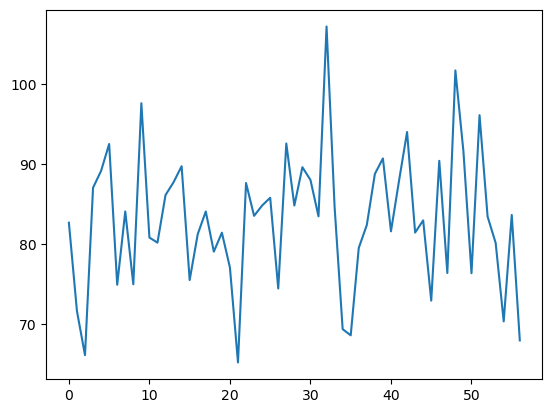

In [25]:
plt.plot(np.arange(57), avg_reward)